In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (silhouette_score, davies_bouldin_score, classification_report, accuracy_score)

warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv ('D:/fyp dataset/shopping_behavior_updated.csv')

In [3]:
dataset.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [5]:
#detect null values
df_null = round(100*(dataset.isnull().sum())/len(dataset), 2)
df_null

Customer ID               0.0
Age                       0.0
Gender                    0.0
Item Purchased            0.0
Category                  0.0
Purchase Amount (USD)     0.0
Location                  0.0
Size                      0.0
Color                     0.0
Season                    0.0
Review Rating             0.0
Subscription Status       0.0
Shipping Type             0.0
Discount Applied          0.0
Promo Code Used           0.0
Previous Purchases        0.0
Payment Method            0.0
Frequency of Purchases    0.0
dtype: float64

In [6]:
duplicate_rows = dataset.duplicated().sum()
duplicate_rows

0

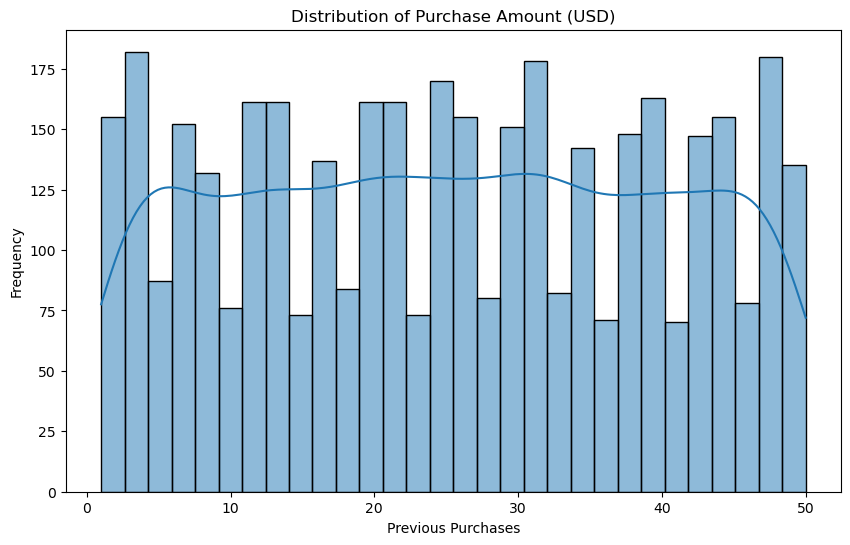

In [7]:
# Visualizations

## Distribution of Purchase Amount
plt.figure(figsize=(10, 6))
sns.histplot(dataset['Previous Purchases'], bins=30, kde=True)
plt.title('Distribution of Purchase Amount (USD)')
plt.xlabel('Previous Purchases')
plt.ylabel('Frequency')
plt.show()

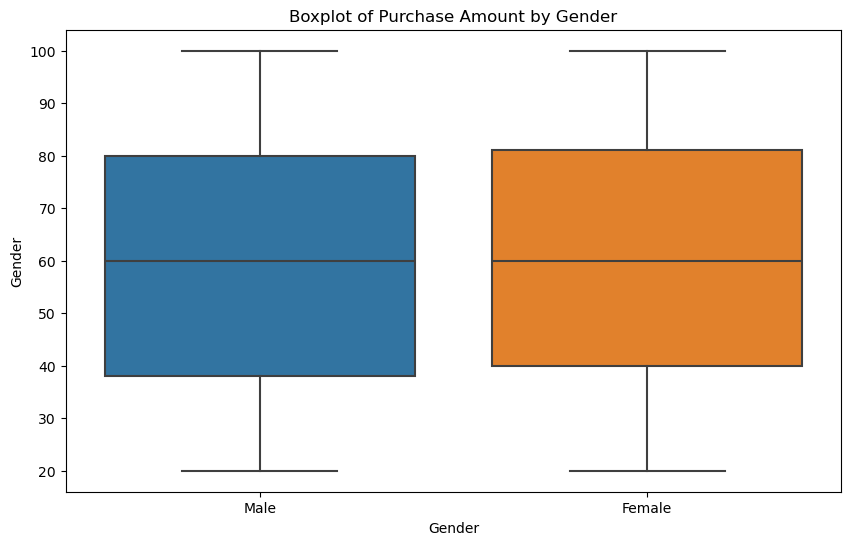

In [8]:
## Boxplot of Purchase Amount by Gender
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset, x='Gender', y='Purchase Amount (USD)')
plt.title('Boxplot of Purchase Amount by Gender')
plt.ylabel('Gender')
plt.show()

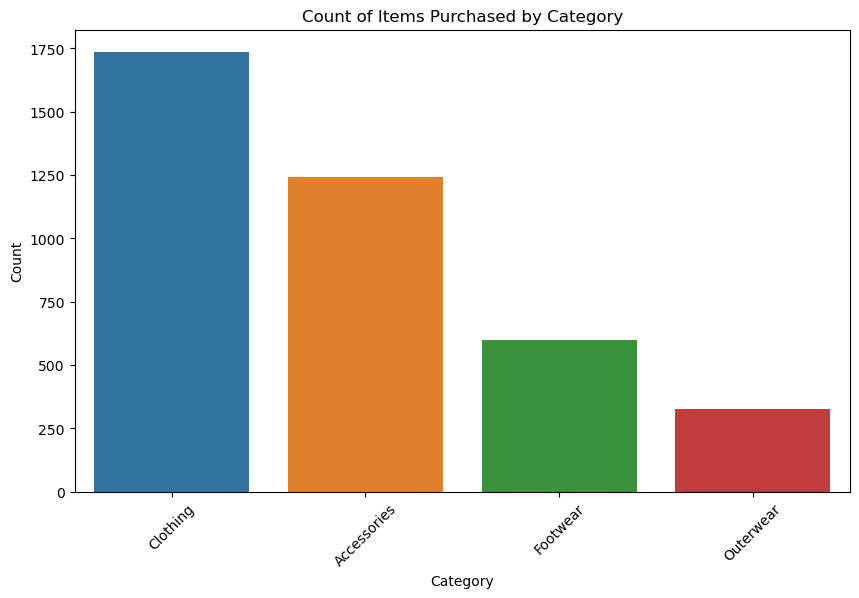

In [9]:
## Count of Items Purchased by Category
plt.figure(figsize=(10, 6))
sns.countplot(data=dataset, x='Category', order=dataset['Category'].value_counts().index)
plt.title('Count of Items Purchased by Category')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [10]:
# Initialize scalers
scaler = MinMaxScaler()
label_encoder = LabelEncoder()

# Identify categorical and numerical features
categorical_features = ['Gender', 'Location', 'Size', 'Color', 'Season', 'Category', 'Review Rating', 
                        'Subscription Status', 'Discount Applied', 'Promo Code Used', 'Frequency of Purchases']
numerical_features = ['Previous Purchases', 'Purchase Amount (USD)']

# Label Encode categorical features
for col in categorical_features:
    dataset[col] = label_encoder.fit_transform(dataset[col])

# Normalize categorical and numerical features
dataset[categorical_features] = scaler.fit_transform(dataset[categorical_features])
dataset[numerical_features] = scaler.fit_transform(dataset[numerical_features])

# Feature Engineering

# **1. Total Spend** - Calculating cumulative spending based on normalized previous purchases & purchase amount
dataset['Total Spend'] = dataset['Previous Purchases'] * dataset['Purchase Amount (USD)']
dataset['Total Spend'] = scaler.fit_transform(dataset[['Total Spend']])  # Normalize again

# **2. Customer Characteristics** - Combining Age, Gender, and Location
dataset['customer_characteristics'] = (
    dataset['Age'].astype(str) + dataset['Gender'].astype(str) + dataset['Location'].astype(str)
)
dataset['customer_characteristics'] = label_encoder.fit_transform(dataset['customer_characteristics'])
dataset['customer_characteristics'] = scaler.fit_transform(dataset[['customer_characteristics']])

# **3. Purchase Behavior** - Combining Size, Color, Season, Category, and Review Rating
dataset['purchase_behavior'] = (
    dataset['Size'].astype(str) + dataset['Color'].astype(str) + dataset['Season'].astype(str) + 
    dataset['Category'].astype(str) + dataset['Review Rating'].astype(str)
)
dataset['purchase_behavior'] = label_encoder.fit_transform(dataset['purchase_behavior'])
dataset['purchase_behavior'] = scaler.fit_transform(dataset[['purchase_behavior']])

# **4. Customer Loyalty Score** - Calculated based on different factors
def loyalty_score(row):
    score = 0
    if row['Subscription Status'] > 0.5:  # Normalized values
        score += 5
    if row['Frequency of Purchases'] > 0.8:  # Weekly (after normalization)
        score += 3
    elif row['Frequency of Purchases'] > 0.6:  # Fortnightly
        score += 2
    elif row['Frequency of Purchases'] > 0.3:  # Annually
        score += 1
    score += row['Previous Purchases'] * 10  # Scaled up after normalization
    if row['Discount Applied'] > 0.5:
        score += 2
    if row['Promo Code Used'] > 0.5:
        score += 2
    return score

# Apply Loyalty Score Calculation
dataset['Loyalty Score'] = dataset.apply(loyalty_score, axis=1)
dataset['Loyalty Score'] = scaler.fit_transform(dataset[['Loyalty Score']])  # Normalize Loyalty Score

# **5. Composite Score Calculation**
dataset['Composite Score'] = (
    dataset['Loyalty Score'] * 0.4 + 
    dataset['Total Spend'] * 0.3 + 
    dataset['customer_characteristics'] * 0.2 + 
    dataset['purchase_behavior'] * 0.1
)

dataset.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,...,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Total Spend,customer_characteristics,purchase_behavior,Loyalty Score,Composite Score
0,1,55,1.0,Blouse,0.333333,0.4125,0.326531,0.000000,0.291667,1.000000,...,1.0,1.0,0.265306,Venmo,0.5,0.109439,0.708947,0.082457,0.575139,0.412922
1,2,19,1.0,Sweater,0.333333,0.5500,0.367347,0.000000,0.500000,1.000000,...,1.0,1.0,0.020408,Cash,0.5,0.011224,0.030578,0.135584,0.463822,0.208570
2,3,50,1.0,Jeans,0.333333,0.6625,0.408163,0.666667,0.500000,0.333333,...,1.0,1.0,0.448980,Credit Card,1.0,0.297449,0.613817,0.795241,0.749536,0.591337
3,4,21,1.0,Sandals,0.666667,0.8750,0.775510,0.333333,0.500000,0.333333,...,1.0,1.0,0.979592,PayPal,1.0,0.857143,0.067195,0.492529,0.990724,0.716124
4,5,45,1.0,Blouse,0.333333,0.3625,0.734694,0.333333,0.875000,0.333333,...,1.0,1.0,0.612245,PayPal,0.0,0.221939,0.523216,0.643885,0.687384,0.510567


Feature Correlation Coefficients:
                          Customer ID       Age    Gender  Item Purchased  \
Customer ID                  1.000000 -0.004079 -0.807960        0.003648   
Age                         -0.004079  1.000000  0.002763       -0.000636   
Gender                      -0.807960  0.002763  1.000000        0.001921   
Item Purchased               0.003648 -0.000636  0.001921        1.000000   
Category                    -0.004133  0.003546 -0.004144        0.052951   
Purchase Amount (USD)        0.011048 -0.010424 -0.014044       -0.005342   
Location                    -0.013257 -0.001957  0.000747        0.020390   
Size                        -0.001801 -0.023654  0.018764       -0.008942   
Color                       -0.011144  0.006700 -0.000560        0.027241   
Season                      -0.018027 -0.028418  0.016258        0.012755   
Review Rating                0.001343 -0.021949  0.008164       -0.004621   
Subscription Status         -0.768960  0.0

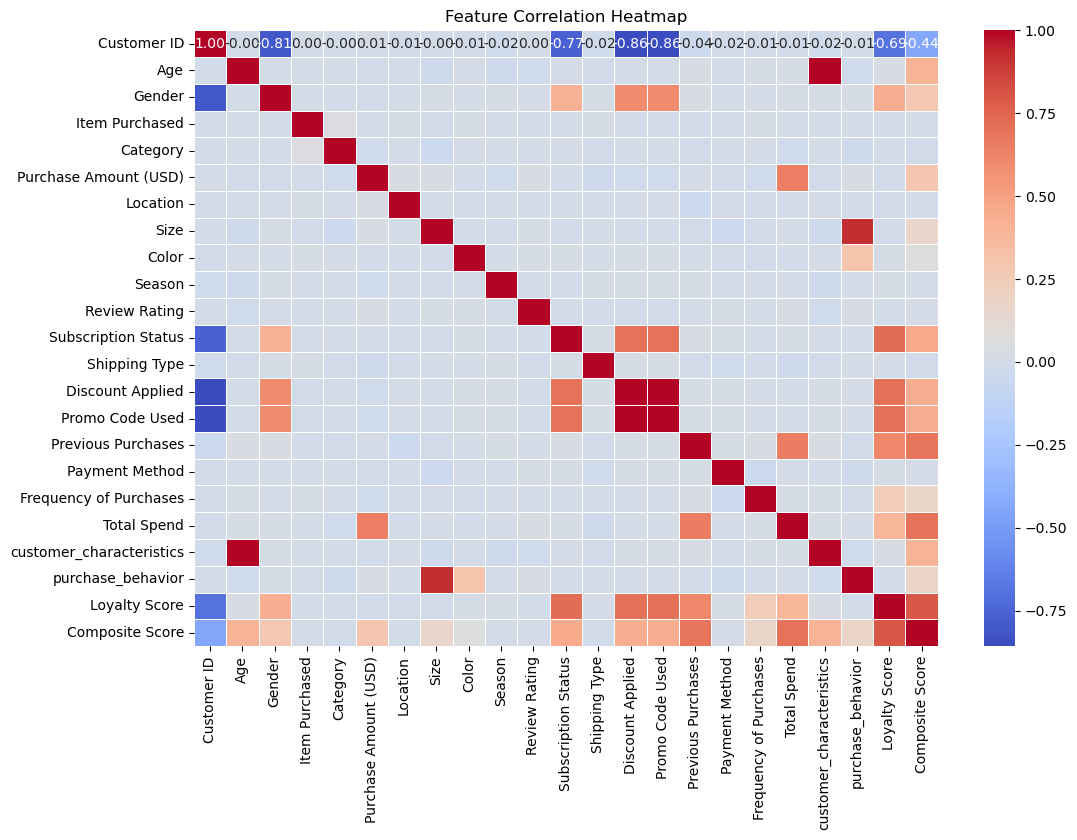

In [11]:
# Convert categorical features to numeric using Label Encoding
label_encoders = {}  # Store label encoders for reference
for column in dataset.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset[column] = le.fit_transform(dataset[column])  # Convert to numeric
    label_encoders[column] = le  # Store encoder for future use

# Compute correlation matrix
correlation_matrix = dataset.corr()

# Display correlation matrix
print("Feature Correlation Coefficients:")
print(correlation_matrix)

# Plot heatmap for visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [12]:
#PCA
# Select relevant features for dimensionality reduction
features = dataset[['Composite Score', 'Total Spend' ]]  # Adjust as necessary

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

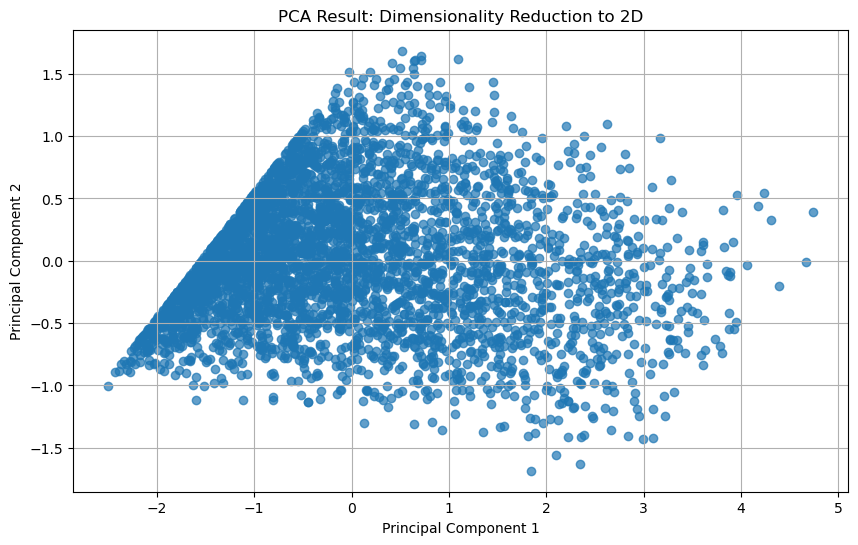

Explained Variance Ratio: [0.85035521 0.14964479]


In [13]:
# Visualize the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.title('PCA Result: Dimensionality Reduction to 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

# Explained variance ratio
print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')

Original dataset size: 3900, After outlier removal: 3798


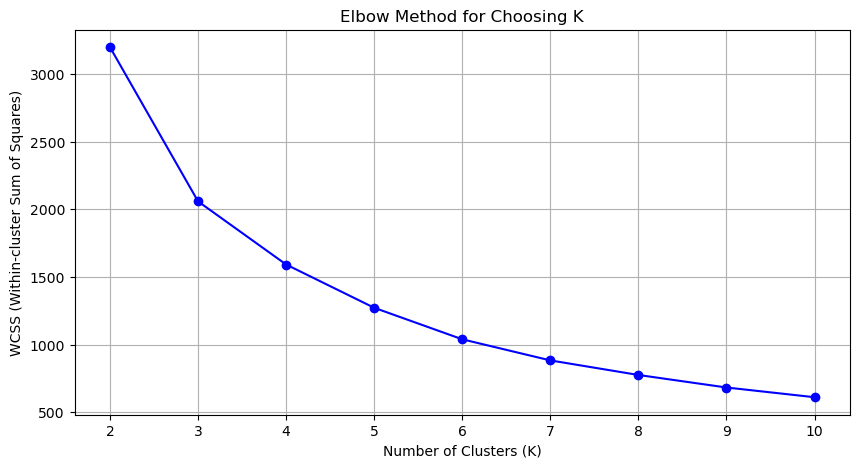

Silhouette Score for DBSCAN: 0.48
Silhouette Score for K-Means (K=3): 0.41
Silhouette Score for GMM (n=3): 0.26


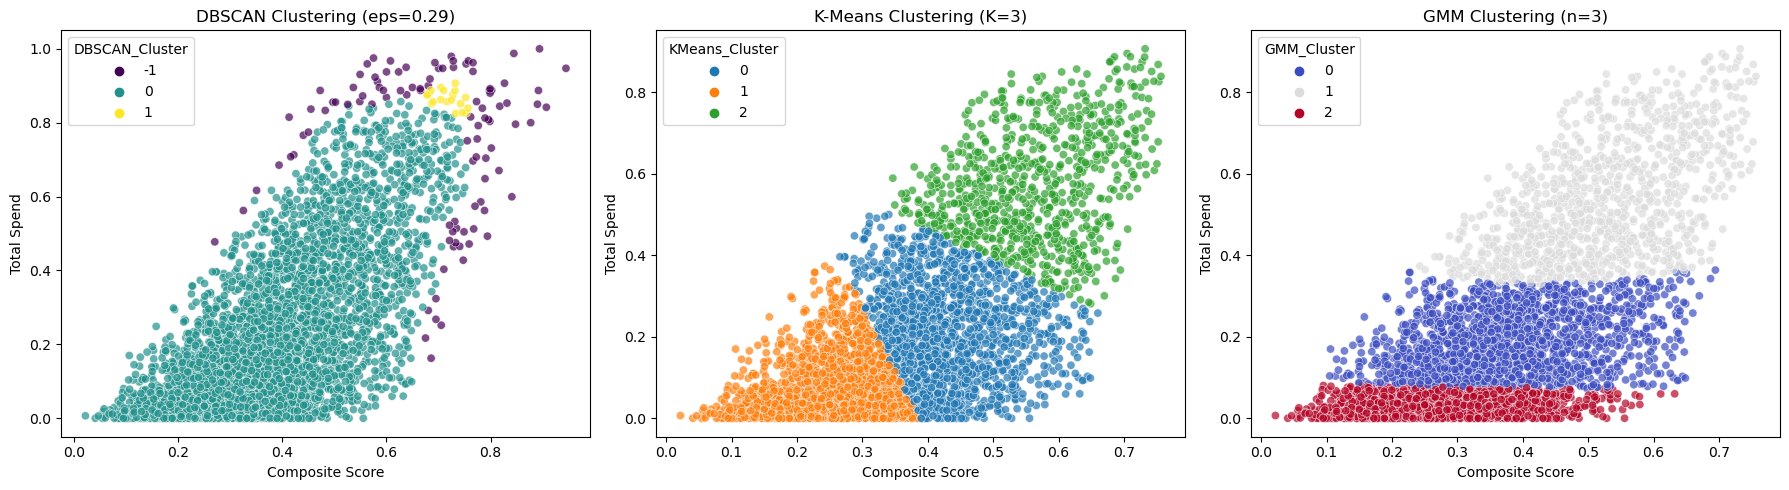

In [14]:
# Select relevant features for clustering
features = dataset[['Composite Score', 'Total Spend']]

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# -------------------------------
# 🔹 STEP 1: Perform DBSCAN
# -------------------------------
eps = 0.29  # Adjust based on knee point from K-distance plot
min_samples = 30  # Adjust based on dataset size
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(scaled_features)

# Assign DBSCAN cluster labels to the dataset
dataset['DBSCAN_Cluster'] = dbscan_labels

# -------------------------------
# 🔹 STEP 2: Detect Outliers from DBSCAN & Remove Them
# -------------------------------
dataset_cleaned = dataset[dataset['DBSCAN_Cluster'] != -1]  # Removing outliers
print(f"Original dataset size: {len(dataset)}, After outlier removal: {len(dataset_cleaned)}")

# Re-scale cleaned data for next clustering steps
scaled_cleaned_features = scaler.fit_transform(dataset_cleaned[['Composite Score', 'Total Spend']])

# -------------------------------
# 🔹 STEP 3: Perform K-Means on Cleaned Data
# -------------------------------
# Finding the best K using the Elbow Method
wcss = []  # Within-cluster sum of squares
K_range = range(2, 11)  # Testing K from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_cleaned_features)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 5))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.title('Elbow Method for Choosing K')
plt.grid()
plt.show()

# Compute Silhouette Score for DBSCAN (ignoring noise points)
dbscan_clusters = dataset[dataset['DBSCAN_Cluster'] != -1]  # Exclude outliers
if len(set(dbscan_clusters['DBSCAN_Cluster'])) > 1:
    silhouette_dbscan = silhouette_score(scaled_features[dbscan_clusters.index], dbscan_clusters['DBSCAN_Cluster'])
    print(f'Silhouette Score for DBSCAN: {silhouette_dbscan:.2f}')
else:
    print("Not enough clusters found to calculate Silhouette Score for DBSCAN.")

# Choose the best K manually
best_k = 3  # Adjust this based on the elbow method

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
dataset_cleaned['KMeans_Cluster'] = kmeans.fit_predict(scaled_cleaned_features)

# Evaluate K-Means Clustering
if len(set(dataset_cleaned['KMeans_Cluster'])) > 1:
    silhouette_kmeans = silhouette_score(scaled_cleaned_features, dataset_cleaned['KMeans_Cluster'])
    print(f'Silhouette Score for K-Means (K={best_k}): {silhouette_kmeans:.2f}')
else:
    print("Not enough clusters found to calculate Silhouette Score for K-Means.")

# -------------------------------
# 🔹 STEP 4: Perform GMM on Cleaned Data
# -------------------------------
n_components = best_k  # Using same value as K-Means
gmm = GaussianMixture(n_components=n_components, random_state=42)
dataset_cleaned['GMM_Cluster'] = gmm.fit_predict(scaled_cleaned_features)

# Evaluate GMM Clustering
if len(set(dataset_cleaned['GMM_Cluster'])) > 1:
    silhouette_gmm = silhouette_score(scaled_cleaned_features, dataset_cleaned['GMM_Cluster'])
    print(f'Silhouette Score for GMM (n={n_components}): {silhouette_gmm:.2f}')
else:
    print("Not enough clusters found to calculate Silhouette Score for GMM.")

# -------------------------------
# 🔹 STEP 5: Visualization of Clustering Results
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# DBSCAN Visualization
sns.scatterplot(ax=axes[0], x=dataset['Composite Score'], y=dataset['Total Spend'], 
                hue=dataset['DBSCAN_Cluster'], palette='viridis', alpha=0.7)
axes[0].set_title(f'DBSCAN Clustering (eps={eps})')
axes[0].set_xlabel('Composite Score')
axes[0].set_ylabel('Total Spend')

# K-Means Visualization
sns.scatterplot(ax=axes[1], x=dataset_cleaned['Composite Score'], y=dataset_cleaned['Total Spend'], 
                hue=dataset_cleaned['KMeans_Cluster'], palette='tab10', alpha=0.7)
axes[1].set_title(f'K-Means Clustering (K={best_k})')
axes[1].set_xlabel('Composite Score')
axes[1].set_ylabel('Total Spend')

# GMM Visualization
sns.scatterplot(ax=axes[2], x=dataset_cleaned['Composite Score'], y=dataset_cleaned['Total Spend'], 
                hue=dataset_cleaned['GMM_Cluster'], palette='coolwarm', alpha=0.7)
axes[2].set_title(f'GMM Clustering (n={n_components})')
axes[2].set_xlabel('Composite Score')
axes[2].set_ylabel('Total Spend')

plt.tight_layout()
plt.show()

In [15]:
# -------------------------------
# 🔹 STEP 6: Mapping K-Means Clusters to Customer Segments
# -------------------------------

# Calculate mean Total Spend for each K-Means cluster
kmeans_means = dataset_cleaned.groupby('KMeans_Cluster')['Total Spend'].mean().sort_values()

# Create a mapping based on sorted order (Low → Medium → High)
kmeans_cluster_mapping = {
    kmeans_means.index[0]: 'Low',
    kmeans_means.index[1]: 'Medium',
    kmeans_means.index[2]: 'High'
}

# Assign the customer value segments
dataset_cleaned['KMeans_Segment'] = dataset_cleaned['KMeans_Cluster'].map(kmeans_cluster_mapping)

# -------------------------------
# 🔹 STEP 7: Mapping GMM Clusters to Customer Segments
# -------------------------------

# Calculate mean Total Spend for each GMM cluster
gmm_means = dataset_cleaned.groupby('GMM_Cluster')['Total Spend'].mean().sort_values()

# Create a mapping based on sorted order (Low → Medium → High)
gmm_cluster_mapping = {
    gmm_means.index[0]: 'Low',
    gmm_means.index[1]: 'Medium',
    gmm_means.index[2]: 'High'
}

# Assign the customer value segments
dataset_cleaned['GMM_Segment'] = dataset_cleaned['GMM_Cluster'].map(gmm_cluster_mapping)

# -------------------------------
# 🔹 STEP 8: Display the Mapped Segments
# -------------------------------

# Display first few rows to verify
dataset_cleaned.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,...,Total Spend,customer_characteristics,purchase_behavior,Loyalty Score,Composite Score,DBSCAN_Cluster,KMeans_Cluster,GMM_Cluster,KMeans_Segment,GMM_Segment
0,1,55,1.0,2,0.333333,0.4125,0.326531,0.000000,0.291667,1.000000,...,0.109439,0.708947,0.082457,0.575139,0.412922,0,0,0,Medium,Medium
1,2,19,1.0,23,0.333333,0.5500,0.367347,0.000000,0.500000,1.000000,...,0.011224,0.030578,0.135584,0.463822,0.208570,0,1,2,Low,Low
2,3,50,1.0,11,0.333333,0.6625,0.408163,0.666667,0.500000,0.333333,...,0.297449,0.613817,0.795241,0.749536,0.591337,0,0,0,Medium,Medium
3,4,21,1.0,14,0.666667,0.8750,0.775510,0.333333,0.500000,0.333333,...,0.857143,0.067195,0.492529,0.990724,0.716124,1,2,1,High,High
4,5,45,1.0,2,0.333333,0.3625,0.734694,0.333333,0.875000,0.333333,...,0.221939,0.523216,0.643885,0.687384,0.510567,0,0,0,Medium,Medium


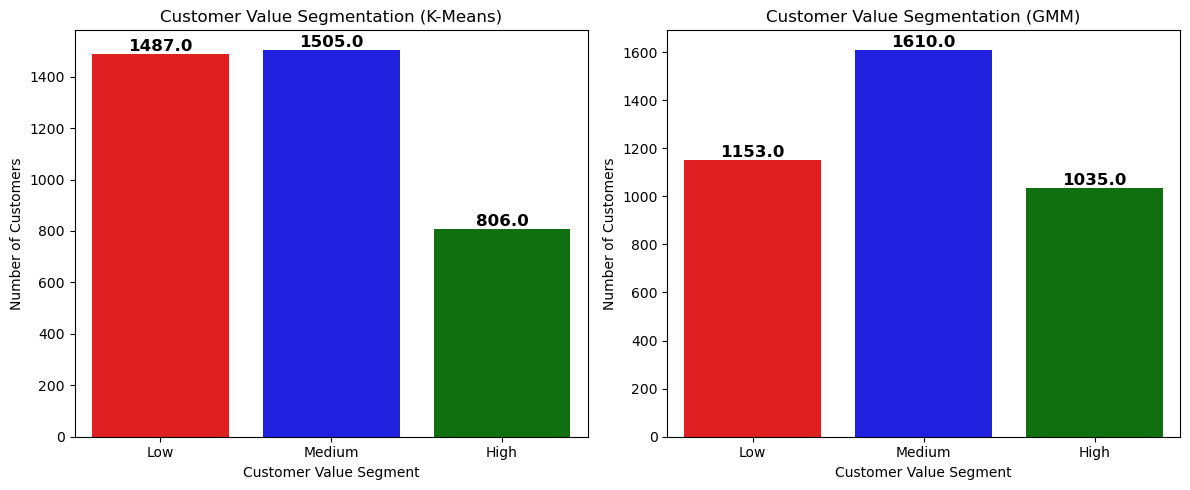

In [16]:
# Define custom colors for the segments
segment_colors = {'Low': 'red', 'Medium': 'blue', 'High': 'green'}

# Set figure size
plt.figure(figsize=(12, 5))

# -------------------------------
# 🔹 Bar Chart for K-Means Segmentation
# -------------------------------
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
ax1 = sns.countplot(x=dataset_cleaned['KMeans_Segment'], 
                     order=['Low', 'Medium', 'High'], 
                     palette=[segment_colors[s] for s in ['Low', 'Medium', 'High']])

# Add value counts on top of bars
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Customer Value Segmentation (K-Means)')
plt.xlabel('Customer Value Segment')
plt.ylabel('Number of Customers')

# -------------------------------
# 🔹 Bar Chart for GMM Segmentation
# -------------------------------
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
ax2 = sns.countplot(x=dataset_cleaned['GMM_Segment'], 
                     order=['Low', 'Medium', 'High'], 
                     palette=[segment_colors[s] for s in ['Low', 'Medium', 'High']])

# Add value counts on top of bars
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Customer Value Segmentation (GMM)')
plt.xlabel('Customer Value Segment')
plt.ylabel('Number of Customers')

# Show plots
plt.tight_layout()
plt.show()

In [17]:
# Copy dataset
df = dataset_cleaned.copy()

# Select features (excluding cluster columns and target variables)
features = df.drop(columns=['DBSCAN_Cluster', 'KMeans_Cluster', 'GMM_Cluster', 'KMeans_Segment', 'GMM_Segment'])

# Encode categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    features[col] = label_encoder.fit_transform(features[col])

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Define targets
target_kmeans = df['KMeans_Cluster']
target_gmm = df['GMM_Cluster']

# Train-test split (80% train, 20% test)
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(
    features_scaled, target_kmeans, test_size=0.2, random_state=42, stratify=target_kmeans)

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    features_scaled, target_gmm, test_size=0.2, random_state=42, stratify=target_gmm)

print(f"✅ Data prepared! Train Size (K-Means): {X_train_k.shape}, Train Size (GMM): {X_train_g.shape}")

✅ Data prepared! Train Size (K-Means): (3038, 23), Train Size (GMM): (3038, 23)


In [18]:
dt_params = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}
dt = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy', return_train_score=True)
dt.fit(X_train_k, y_train_k)

# Print all results
cv_results = pd.DataFrame(dt.cv_results_)[['param_max_depth', 'param_min_samples_split', 'mean_test_score']]
cv_results

,param_max_depth,param_min_samples_split,mean_test_score
0,3,2,0.917716
1,3,5,0.917716
2,3,10,0.917716
3,5,2,0.969063
4,5,5,0.969063
5,5,10,0.969392
6,10,2,0.977620
7,10,5,0.974986
8,10,10,0.977948
9,None,2,0.977620


In [19]:
# Print best parameters & best score
print("\n✅ Best Parameters:", dt.best_params_)
print("✅ Best Accuracy Score:", dt.best_score_)

# Final prediction
y_pred_k_dt = dt.best_estimator_.predict(X_test_k)

print("\n🎯 Decision Tree (K-Means) - Final Evaluation")
print(classification_report(y_test_k, y_pred_k_dt))


✅ Best Parameters: {'max_depth': 10, 'min_samples_split': 10}
✅ Best Accuracy Score: 0.9779475201595421

🎯 Decision Tree (K-Means) - Final Evaluation
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       301
           1       0.98      0.99      0.98       298
           2       0.99      0.98      0.98       161

    accuracy                           0.98       760
   macro avg       0.98      0.98      0.98       760
weighted avg       0.98      0.98      0.98       760



In [20]:
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, None]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', return_train_score=True)
rf.fit(X_train_k, y_train_k)

print("\n🔹 Random Forest: Hyperparameter Tuning Results")
kmeans_rf_result = pd.DataFrame(rf.cv_results_)[['param_n_estimators', 'param_max_depth', 'mean_test_score']]
kmeans_rf_result


🔹 Random Forest: Hyperparameter Tuning Results


,param_n_estimators,param_max_depth,mean_test_score
0,50,3,0.916072
1,100,3,0.915741
2,200,3,0.912451
3,50,5,0.949317
4,100,5,0.947011
5,200,5,0.949316
6,50,None,0.968076
7,100,None,0.970710
8,200,None,0.971696


In [21]:
print("\n✅ Best Parameters:", rf.best_params_)
print("✅ Best Accuracy Score:", rf.best_score_)

y_pred_k_rf = rf.best_estimator_.predict(X_test_k)
print("\n🎯 Random Forest (K-Means) - Final Evaluation")
print(classification_report(y_test_k, y_pred_k_rf))


✅ Best Parameters: {'max_depth': None, 'n_estimators': 200}
✅ Best Accuracy Score: 0.9716964363131882

🎯 Random Forest (K-Means) - Final Evaluation
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       301
           1       0.98      0.97      0.98       298
           2       0.97      0.99      0.98       161

    accuracy                           0.97       760
   macro avg       0.97      0.98      0.97       760
weighted avg       0.97      0.97      0.97       760



In [22]:
gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
gb = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5, scoring='accuracy', return_train_score=True)
gb.fit(X_train_k, y_train_k)

print("\n🔹 Gradient Boosting: Hyperparameter Tuning Results")
kmeans_gb_result = pd.DataFrame(gb.cv_results_)[['param_n_estimators', 'param_learning_rate', 'mean_test_score']]
kmeans_gb_result


🔹 Gradient Boosting: Hyperparameter Tuning Results


,param_n_estimators,param_learning_rate,mean_test_score
0,50,0.01,0.952276
1,100,0.01,0.966757
2,200,0.01,0.976633
3,50,0.1,0.984202
4,100,0.1,0.984530
5,200,0.1,0.983542
6,50,0.2,0.983871
7,100,0.2,0.982555
8,200,0.2,0.980910


In [23]:
print("\n✅ Best Parameters:", gb.best_params_)
print("✅ Best Accuracy Score:", gb.best_score_)

y_pred_k_gb = gb.best_estimator_.predict(X_test_k)
print("\n🎯 Gradient Boosting (K-Means) - Final Evaluation")
print(classification_report(y_test_k, y_pred_k_gb))


✅ Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}
✅ Best Accuracy Score: 0.9845297190670251

🎯 Gradient Boosting (K-Means) - Final Evaluation
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       301
           1       0.99      0.99      0.99       298
           2       0.97      0.99      0.98       161

    accuracy                           0.99       760
   macro avg       0.98      0.99      0.98       760
weighted avg       0.99      0.99      0.99       760



In [24]:
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm = GridSearchCV(SVC(random_state=42), svm_params, cv=5, scoring='accuracy', return_train_score=True)
svm.fit(X_train_k, y_train_k)

print("\n🔹 SVM: Hyperparameter Tuning Results")
kmeans_svm_result = pd.DataFrame(svm.cv_results_)[['param_C', 'param_kernel', 'mean_test_score']]
kmeans_svm_result


🔹 SVM: Hyperparameter Tuning Results


,param_C,param_kernel,mean_test_score
0,0.1,linear,0.971700
1,0.1,rbf,0.919031
2,1,linear,0.985521
3,1,rbf,0.958859
4,10,linear,0.989798
5,10,rbf,0.950630


In [25]:
print("\n✅ Best Parameters:", svm.best_params_)
print("✅ Best Accuracy Score:", svm.best_score_)

y_pred_k_svm = svm.best_estimator_.predict(X_test_k)
print("\n🎯 SVM (K-Means) - Final Evaluation")
print(classification_report(y_test_k, y_pred_k_svm))


✅ Best Parameters: {'C': 10, 'kernel': 'linear'}
✅ Best Accuracy Score: 0.9897977542703547

🎯 SVM (K-Means) - Final Evaluation
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       301
           1       0.99      0.99      0.99       298
           2       0.99      1.00      0.99       161

    accuracy                           0.99       760
   macro avg       0.99      0.99      0.99       760
weighted avg       0.99      0.99      0.99       760



In [26]:
# Define models 
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC()
}

# Store accuracy scores for each model using cross-validation
model_accuracies = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train_k, y_train_k, cv=5, scoring='accuracy')  # 5-fold CV
    model_accuracies[name] = scores
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}, Std Dev = {scores.std():.4f}")

# Convert results into DataFrame
results_df = pd.DataFrame(model_accuracies)

# Perform paired t-tests between models
model_names = list(model_accuracies.keys())

print("\nT-Test Results (p-values):")

for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)):
        model1, model2 = model_names[i], model_names[j]
        t_stat, p_value = ttest_rel(results_df[model1], results_df[model2])
        print(f"{model1} vs {model2}: p-value = {p_value:.4f}")

# Interpretation:
# If p-value < 0.05 → Significant difference between models
# If p-value ≥ 0.05 → No significant difference

Decision Tree: Mean Accuracy = 0.9760, Std Dev = 0.0061
Random Forest: Mean Accuracy = 0.9694, Std Dev = 0.0128
Gradient Boosting: Mean Accuracy = 0.9845, Std Dev = 0.0025
SVM: Mean Accuracy = 0.9589, Std Dev = 0.0069

T-Test Results (p-values):
Decision Tree vs Random Forest: p-value = 0.3831
Decision Tree vs Gradient Boosting: p-value = 0.0752
Decision Tree vs SVM: p-value = 0.0010
Random Forest vs Gradient Boosting: p-value = 0.0575
Random Forest vs SVM: p-value = 0.1032
Gradient Boosting vs SVM: p-value = 0.0022


Decision Tree: Mean Accuracy = 0.9924, Std Dev = 0.0058
Random Forest: Mean Accuracy = 0.9914, Std Dev = 0.0035
Gradient Boosting: Mean Accuracy = 0.9911, Std Dev = 0.0056
SVM: Mean Accuracy = 0.9381, Std Dev = 0.0112


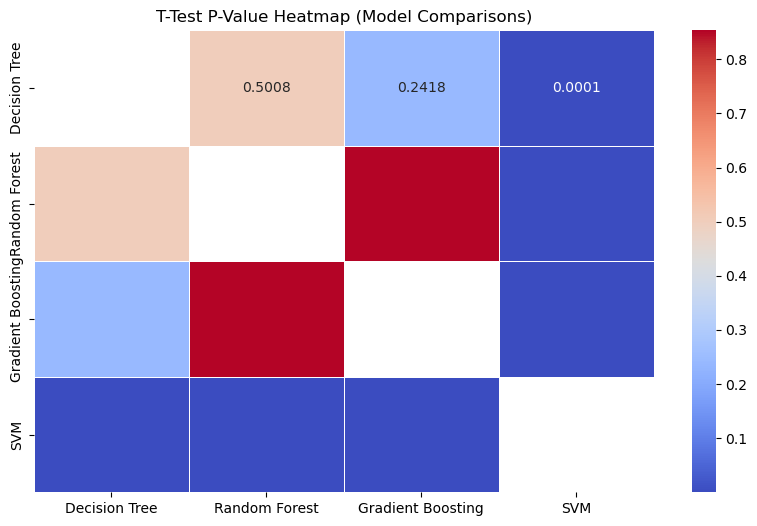

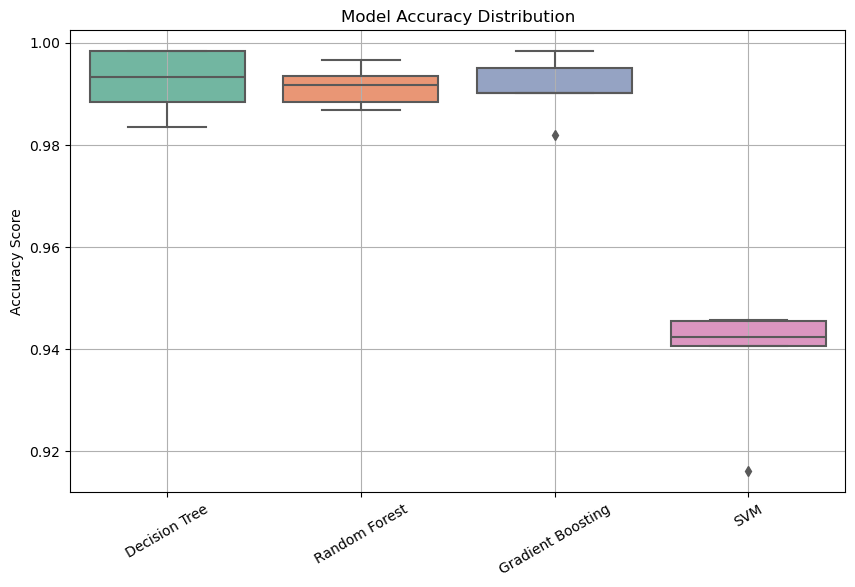

In [27]:
# Define models (Removing Logistic Regression & Linear Regression)
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC()
}

# Store accuracy scores using cross-validation
model_accuracies = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train_g, y_train_g, cv=5, scoring='accuracy')  # 5-fold CV
    model_accuracies[name] = scores
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}, Std Dev = {scores.std():.4f}")

# Convert results into DataFrame
results_df = pd.DataFrame(model_accuracies)

# Create a heatmap matrix for p-values
model_names = list(model_accuracies.keys())
p_values_matrix = np.zeros((len(model_names), len(model_names)))

for i in range(len(model_names)):
    for j in range(len(model_names)):
        if i != j:
            _, p_value = ttest_rel(results_df[model_names[i]], results_df[model_names[j]])
            p_values_matrix[i, j] = p_value
        else:
            p_values_matrix[i, j] = np.nan  # Set diagonal to NaN (self-comparison is not needed)

# Convert to DataFrame
p_values_df = pd.DataFrame(p_values_matrix, index=model_names, columns=model_names)

# 📊 **Heatmap of P-values**
plt.figure(figsize=(10, 6))
sns.heatmap(p_values_df, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)
plt.title("T-Test P-Value Heatmap (Model Comparisons)")
plt.show()

# 📊 **Boxplot of Model Accuracies**
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, palette="Set2")
plt.title("Model Accuracy Distribution")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

In [28]:
dt_params = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}
dt = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy', return_train_score=True)
dt.fit(X_train_g, y_train_g)

# Print all results
gmm_dc_result = pd.DataFrame(dt.cv_results_)[['param_max_depth', 'param_min_samples_split', 'mean_test_score']]
gmm_dc_result

,param_max_depth,param_min_samples_split,mean_test_score
0,3,2,0.986176
1,3,5,0.986176
2,3,10,0.986176
3,5,2,0.991444
4,5,5,0.991444
5,5,10,0.991444
6,10,2,0.992101
7,10,5,0.991773
8,10,10,0.991442
9,None,2,0.992101


In [29]:
# Print best parameters & best score
print("\n✅ Best Parameters:", dt.best_params_)
print("✅ Best Accuracy Score:", dt.best_score_)

# Final prediction
y_pred_g_dt = dt.best_estimator_.predict(X_test_g)

print("\n🎯 Decision Tree (K-Means) - Final Evaluation")
print(classification_report(y_test_g, y_pred_g_dt))


✅ Best Parameters: {'max_depth': 10, 'min_samples_split': 2}
✅ Best Accuracy Score: 0.9921014696956559

🎯 Decision Tree (K-Means) - Final Evaluation
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       322
           1       0.99      1.00      1.00       207
           2       0.99      1.00      1.00       231

    accuracy                           0.99       760
   macro avg       0.99      1.00      0.99       760
weighted avg       0.99      0.99      0.99       760



In [30]:
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, None]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', return_train_score=True)
rf.fit(X_train_g, y_train_g)

print("\n🔹 Random Forest: Hyperparameter Tuning Results")
gmm_rf_result = pd.DataFrame(rf.cv_results_)[['param_n_estimators', 'param_max_depth', 'mean_test_score']]
gmm_rf_result


🔹 Random Forest: Hyperparameter Tuning Results


,param_n_estimators,param_max_depth,mean_test_score
0,50,3,0.970704
1,100,3,0.973007
2,200,3,0.980581
3,50,5,0.986835
4,100,5,0.987492
5,200,5,0.987165
6,50,None,0.990785
7,100,None,0.991772
8,200,None,0.991443


In [31]:
print("\n✅ Best Parameters:", rf.best_params_)
print("✅ Best Accuracy Score:", rf.best_score_)

y_pred_g_rf = rf.best_estimator_.predict(X_test_g)
print("\n🎯 Random Forest (K-Means) - Final Evaluation")
print(classification_report(y_test_g, y_pred_g_rf))


✅ Best Parameters: {'max_depth': None, 'n_estimators': 100}
✅ Best Accuracy Score: 0.991771980404058

🎯 Random Forest (K-Means) - Final Evaluation
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       322
           1       1.00      1.00      1.00       207
           2       0.98      1.00      0.99       231

    accuracy                           0.99       760
   macro avg       0.99      0.99      0.99       760
weighted avg       0.99      0.99      0.99       760



In [32]:
gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
gb = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5, scoring='accuracy', return_train_score=True)
gb.fit(X_train_g, y_train_g)

print("\n🔹 Gradient Boosting: Hyperparameter Tuning Results")
gmm_gb_result = pd.DataFrame(gb.cv_results_)[['param_n_estimators', 'param_learning_rate', 'mean_test_score']]
gmm_gb_result


🔹 Gradient Boosting: Hyperparameter Tuning Results


,param_n_estimators,param_learning_rate,mean_test_score
0,50,0.01,0.989140
1,100,0.01,0.989140
2,200,0.01,0.989798
3,50,0.1,0.993089
4,100,0.1,0.990784
5,200,0.1,0.990455
6,50,0.2,0.990126
7,100,0.2,0.989797
8,200,0.2,0.990126


In [33]:
print("\n✅ Best Parameters:", gb.best_params_)
print("✅ Best Accuracy Score:", gb.best_score_)

y_pred_g_gb = gb.best_estimator_.predict(X_test_g)
print("\n🎯 Gradient Boosting (K-Means) - Final Evaluation")
print(classification_report(y_test_g, y_pred_g_gb))


✅ Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}
✅ Best Accuracy Score: 0.9930893956472732

🎯 Gradient Boosting (K-Means) - Final Evaluation
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       322
           1       0.99      1.00      1.00       207
           2       0.99      1.00      1.00       231

    accuracy                           0.99       760
   macro avg       0.99      1.00      0.99       760
weighted avg       0.99      0.99      0.99       760



In [34]:
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm = GridSearchCV(SVC(random_state=42), svm_params, cv=5, scoring='accuracy', return_train_score=True)
svm.fit(X_train_g, y_train_g)

print("\n🔹 SVM: Hyperparameter Tuning Results")
gmm_svm_result = pd.DataFrame(svm.cv_results_)[['param_C', 'param_kernel', 'mean_test_score']]
gmm_svm_result


🔹 SVM: Hyperparameter Tuning Results


,param_C,param_kernel,mean_test_score
0,0.1,linear,0.962149
1,0.1,rbf,0.877225
2,1,linear,0.977617
3,1,rbf,0.938121
4,10,linear,0.982225
5,10,rbf,0.944040


In [35]:
print("\n✅ Best Parameters:", svm.best_params_)
print("✅ Best Accuracy Score:", svm.best_score_)

y_pred_g_svm = svm.best_estimator_.predict(X_test_g)
print("\n🎯 SVM (K-Means) - Final Evaluation")
print(classification_report(y_test_g, y_pred_g_svm))


✅ Best Parameters: {'C': 10, 'kernel': 'linear'}
✅ Best Accuracy Score: 0.9822254617185469

🎯 SVM (K-Means) - Final Evaluation
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       322
           1       0.99      1.00      0.99       207
           2       0.99      1.00      0.99       231

    accuracy                           0.99       760
   macro avg       0.99      0.99      0.99       760
weighted avg       0.99      0.99      0.99       760



In [36]:
# Define models (excluding Logistic Regression)
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC()
}

# Store accuracy scores for each model using cross-validation
model_accuracies = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train_g, y_train_g, cv=5, scoring='accuracy')  # 5-fold CV
    model_accuracies[name] = scores
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}, Std Dev = {scores.std():.4f}")

# Convert results into DataFrame
results_df = pd.DataFrame(model_accuracies)

# Perform paired t-tests between models
model_names = list(model_accuracies.keys())

print("\nT-Test Results (p-values):")

for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)):
        model1, model2 = model_names[i], model_names[j]
        t_stat, p_value = ttest_rel(results_df[model1], results_df[model2])
        print(f"{model1} vs {model2}: p-value = {p_value:.4f}")

# Interpretation:
# If p-value < 0.05 → Significant difference between models
# If p-value ≥ 0.05 → No significant difference

Decision Tree: Mean Accuracy = 0.9924, Std Dev = 0.0061
Random Forest: Mean Accuracy = 0.9908, Std Dev = 0.0052
Gradient Boosting: Mean Accuracy = 0.9908, Std Dev = 0.0057
SVM: Mean Accuracy = 0.9381, Std Dev = 0.0112

T-Test Results (p-values):
Decision Tree vs Random Forest: p-value = 0.4130
Decision Tree vs Gradient Boosting: p-value = 0.1419
Decision Tree vs SVM: p-value = 0.0001
Random Forest vs Gradient Boosting: p-value = 0.9993
Random Forest vs SVM: p-value = 0.0004
Gradient Boosting vs SVM: p-value = 0.0001


Decision Tree: Mean Accuracy = 0.9924, Std Dev = 0.0052
Random Forest: Mean Accuracy = 0.9905, Std Dev = 0.0045
Gradient Boosting: Mean Accuracy = 0.9905, Std Dev = 0.0058
SVM: Mean Accuracy = 0.9381, Std Dev = 0.0112


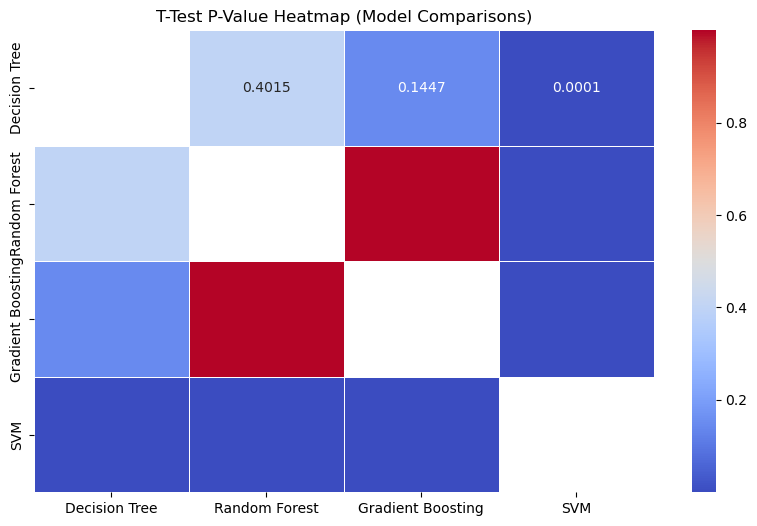

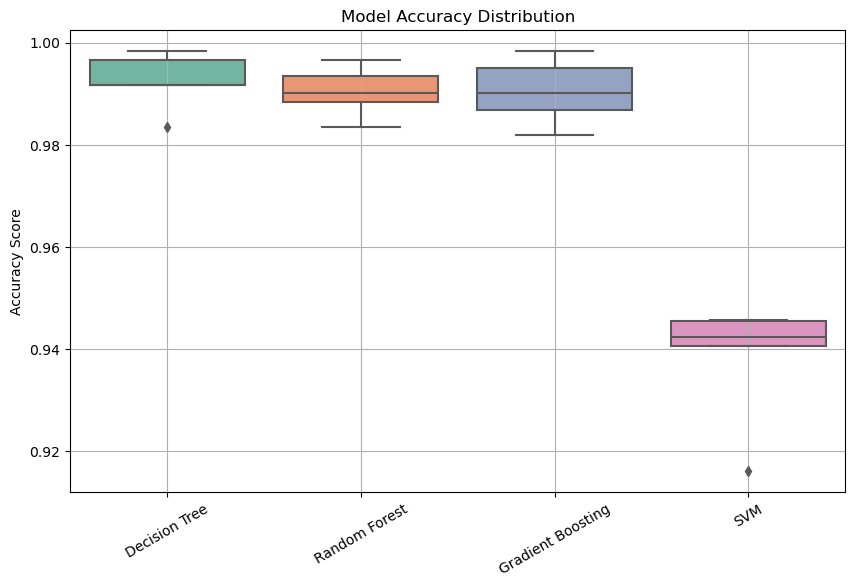

In [37]:
# Define models (Removing Logistic Regression & Linear Regression)
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC()
}

# Store accuracy scores using cross-validation
model_accuracies = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train_g, y_train_g, cv=5, scoring='accuracy')  # 5-fold CV
    model_accuracies[name] = scores
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}, Std Dev = {scores.std():.4f}")

# Convert results into DataFrame
results_df = pd.DataFrame(model_accuracies)

# Create a heatmap matrix for p-values
model_names = list(model_accuracies.keys())
p_values_matrix = np.zeros((len(model_names), len(model_names)))

for i in range(len(model_names)):
    for j in range(len(model_names)):
        if i != j:
            _, p_value = ttest_rel(results_df[model_names[i]], results_df[model_names[j]])
            p_values_matrix[i, j] = p_value
        else:
            p_values_matrix[i, j] = np.nan  # Set diagonal to NaN (self-comparison is not needed)

# Convert to DataFrame
p_values_df = pd.DataFrame(p_values_matrix, index=model_names, columns=model_names)

# 📊 **Heatmap of P-values**
plt.figure(figsize=(10, 6))
sns.heatmap(p_values_df, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)
plt.title("T-Test P-Value Heatmap (Model Comparisons)")
plt.show()

# 📊 **Boxplot of Model Accuracies**
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, palette="Set2")
plt.title("Model Accuracy Distribution")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=30)
plt.grid(True)
plt.show()